# <span style="color: blue;">Projeto de Business Analytics - Defeitos de Fabricação em Garrafas de Vidro</span>

## <span style="color: blue;">Base de dados de Aproximadamente 480mil registros</span>

### Objetivo:

Criar um modelo de Machine Learning que propoe a estabilidade e melhoria do defeito de fabricação 'Parede Fina' Mínimo de 1,10mm. Garrafas com espessura maiores que 1,10mm estão aprovadas, senão reprovadas<p>
Variáveis disponíveis para estudo: espessura da parede, temperatura da gota, temperatura da forma, pressão de trabalho, temperatura da archa de recozimento, produto aprovado e número da secção.<p>
O modelo proposto indicará quais variáveis influenciarão e provocarão os defeitos e poderá ser utilizado das seguinte formas:
- Utilizado em um dashboard, em tempo real, na área quente, onde o indicativo de parede fina influenciará a intervenção do operador da máquina IS.
- Ou como automação, servindo de base a um software que manipulará diretamente o sistema da máquina IS para regulagem das variáveis.

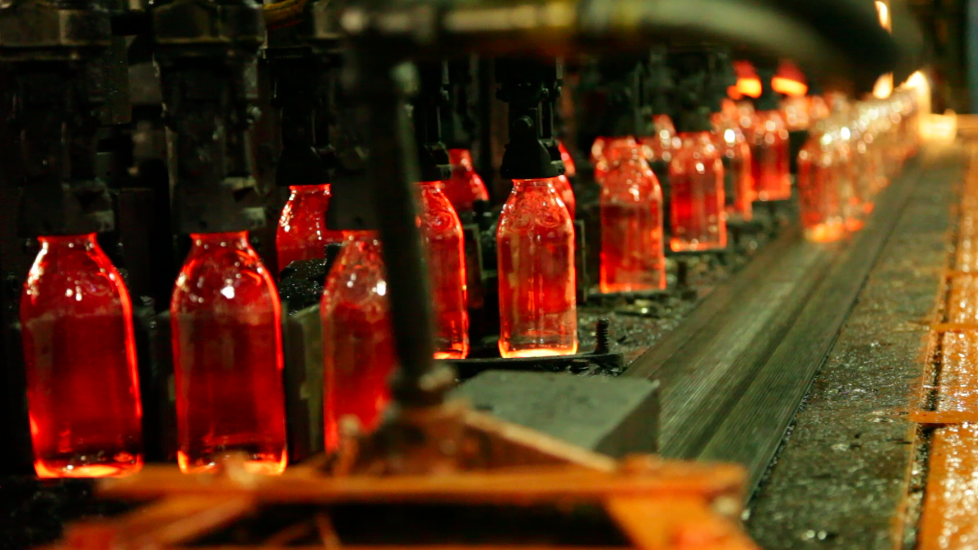

In [1]:
from IPython.display import Image
Image('dados/garrafa.png')

In [2]:
# Imports

# Manipulação de dados
import pandas as pd
import numpy as np

# Visualização
import matplotlib.pyplot as plt
import seaborn as sns

# Estatística
import scipy
from scipy.stats import normaltest
from scipy.stats import chi2_contingency

# Machine learning 
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
from sklearn.metrics import classification_report
from sklearn.neighbors import KNeighborsClassifier
import xgboost as xgb
from imblearn.over_sampling import SMOTE
from collections import Counter

# Ignore Warning
import sys
import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")
    
# Versões dos pacotes usados neste jupyter notebook
%reload_ext watermark
%watermark -a "Data Science Academy" --iversions

# importar os módulos de sistema
import math
import sys, os

# Vamos adicionar caminho para os módulos Python
sys.path.append(os.path.abspath(os.path.join('00')))
from estrategia1 import *
from estrategia2 import *
from estrategia3 import *
import estrategia4

Author: Data Science Academy

scipy     : 1.10.0
sys       : 3.10.9 | packaged by Anaconda, Inc. | (main, Mar  1 2023, 18:18:15) [MSC v.1916 64 bit (AMD64)]
xgboost   : 1.7.5
numpy     : 1.23.5
matplotlib: 3.7.1
pandas    : 1.5.3
seaborn   : 0.12.2



## Análise Exploratória

In [3]:
# importar Dataset
df = pd.read_csv('dados/dados.csv')

In [4]:
df.shape

(479891, 7)

In [5]:
# amostra dos dados
df.sample(10)

,espessura,temp_gota,temp_forma,pressao,temp_archa,aprovado,molde
49457,1.200094,825.831644,314.384457,107.920779,212.165158,1,2
357437,1.144458,820.943694,311.682055,102.587736,213.129885,1,12
111250,1.145436,821.848732,309.769805,108.601811,221.998148,1,4
256173,1.201206,829.118047,311.541965,105.468362,210.302741,1,9
16845,1.159747,825.606430,309.349274,107.059180,207.327146,1,1
89981,1.169248,818.194484,315.744444,105.891710,211.539124,1,3
112352,1.185525,827.946256,313.580914,103.981453,205.801491,1,4
149200,1.209286,827.653233,313.362762,103.839472,231.393124,1,5
36169,1.068381,820.181490,307.160853,102.234645,204.986030,0,2
424662,1.262852,828.390701,317.521036,105.569373,219.372155,1,15


In [6]:
# tipos dos dados
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 479891 entries, 0 to 479890
Data columns (total 7 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   espessura   479891 non-null  float64
 1   temp_gota   479891 non-null  float64
 2   temp_forma  479891 non-null  float64
 3   pressao     479891 non-null  float64
 4   temp_archa  479891 non-null  float64
 5   aprovado    479891 non-null  int64  
 6   molde       479891 non-null  int64  
dtypes: float64(5), int64(2)
memory usage: 25.6 MB


In [7]:
# dados numericos
df_num = list(df.columns[0:5])
df_num

['espessura', 'temp_gota', 'temp_forma', 'pressao', 'temp_archa']

In [8]:
# dados categoricos
df_cat = list(df.columns[5:])
df_cat

['aprovado', 'molde']

In [9]:
# Criando tabelas de frequências
for coluna in df_cat:
    # criando a tabela de frequência para a coluna atual
    freq_table = pd.DataFrame({'Freq. Absoluta': df[coluna].value_counts(dropna=False).fillna('NA'),
                               'Freq. Relativa': (df[coluna].value_counts(normalize=True, dropna=False) * 100).fillna('NA').round(1),
                               'Freq. Acumulada': (df[coluna].value_counts(normalize=True, dropna=False).cumsum() * 100).fillna('NA').round(1)})
    
    # imprimindo a tabela de frequência
    print(f'Tabela de Frequência - variável: {coluna}\n{"-"*70}\n{freq_table}\n{"-"*70}\n\n')

Tabela de Frequência - variável: aprovado
----------------------------------------------------------------------
   Freq. Absoluta  Freq. Relativa  Freq. Acumulada
1          445166            92.8             92.8
0           34725             7.2            100.0
----------------------------------------------------------------------


Tabela de Frequência - variável: molde
----------------------------------------------------------------------
    Freq. Absoluta  Freq. Relativa  Freq. Acumulada
1            29999             6.3              6.3
8            29999             6.3             12.5
2            29997             6.3             18.8
9            29997             6.3             25.0
5            29996             6.3             31.3
15           29996             6.3             37.5
3            29995             6.3             43.8
7            29995             6.3             50.0
10           29995             6.3             56.3
16           29995             

In [10]:
# Medidas de resumo em colunas numéricas
df[df_num].describe()

,espessura,temp_gota,temp_forma,pressao,temp_archa
count,479891.000000,479891.000000,479891.000000,479891.000000,479891.000000
mean,1.170035,823.533331,313.252937,104.341955,210.491698
std,0.048004,5.239594,3.131307,2.150460,7.356066
min,0.948964,799.396205,298.129926,94.427222,178.474252
25%,1.137676,819.995909,311.142974,102.892280,205.533428
50%,1.170039,823.532443,313.256092,104.339368,210.482026
75%,1.202471,827.065019,315.367226,105.791569,215.454165
max,1.401662,847.184428,328.355701,114.325215,242.998836


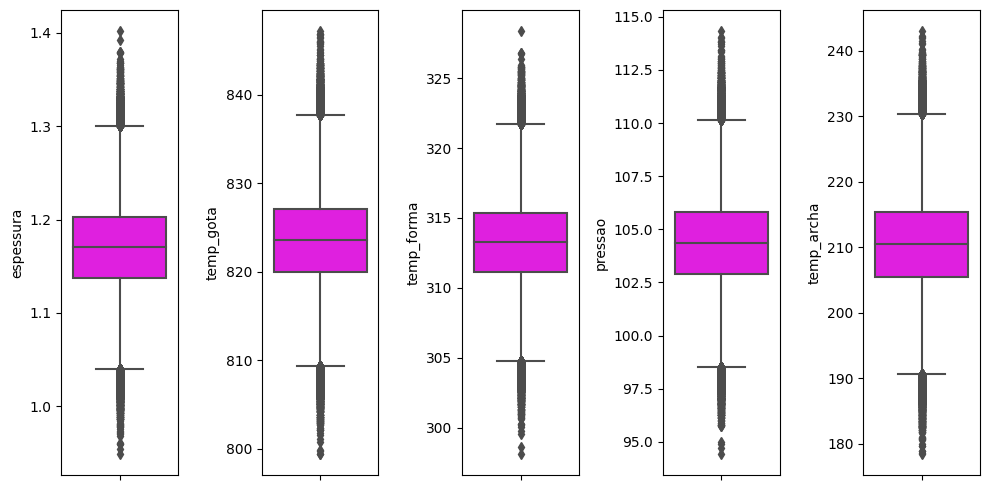

In [11]:
# Boxplots em colunas numéricas
features = df_num
plt.figure(figsize = (10, 5))
for i in range(0, len(features)):
    plt.subplot(1, len(features), i + 1)
    sns.boxplot(y = df[features[i]], color = 'magenta', orient = 'v')
    plt.tight_layout()

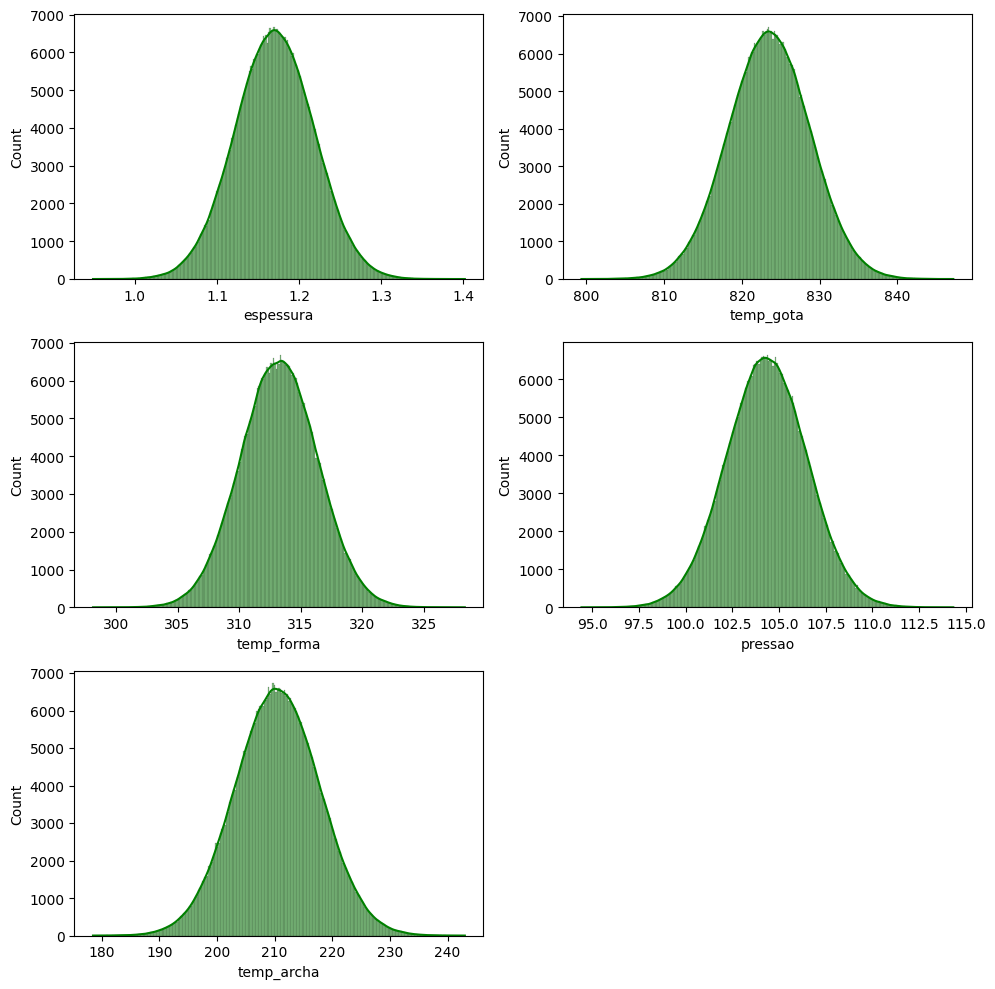

In [12]:
# Histogramas em colunas numéricas
features = df_num
plt.figure(figsize = (10, 10))
for i in range(len(features)):
    plt.subplot(3, len(features)//2, i+1)
    sns.histplot(x=df[features[i]], kde=True, color='green')
    plt.xlabel(features[i])
plt.tight_layout()

In [13]:
# teste de checagem de distribuições normais
for i in df_num:
    
    # Calcula a normalidade
    stats, pval = normaltest(df[i])
    
     # Checar p-valor
    if pval > 0.05:
        print(i, ': Distribuição Normal')
    else:
        print(i, ': Distribuição Não Normal')

espessura : Distribuição Normal
temp_gota : Distribuição Normal
temp_forma : Distribuição Normal
pressao : Distribuição Normal
temp_archa : Distribuição Normal


<Figure size 1500x1500 with 0 Axes>

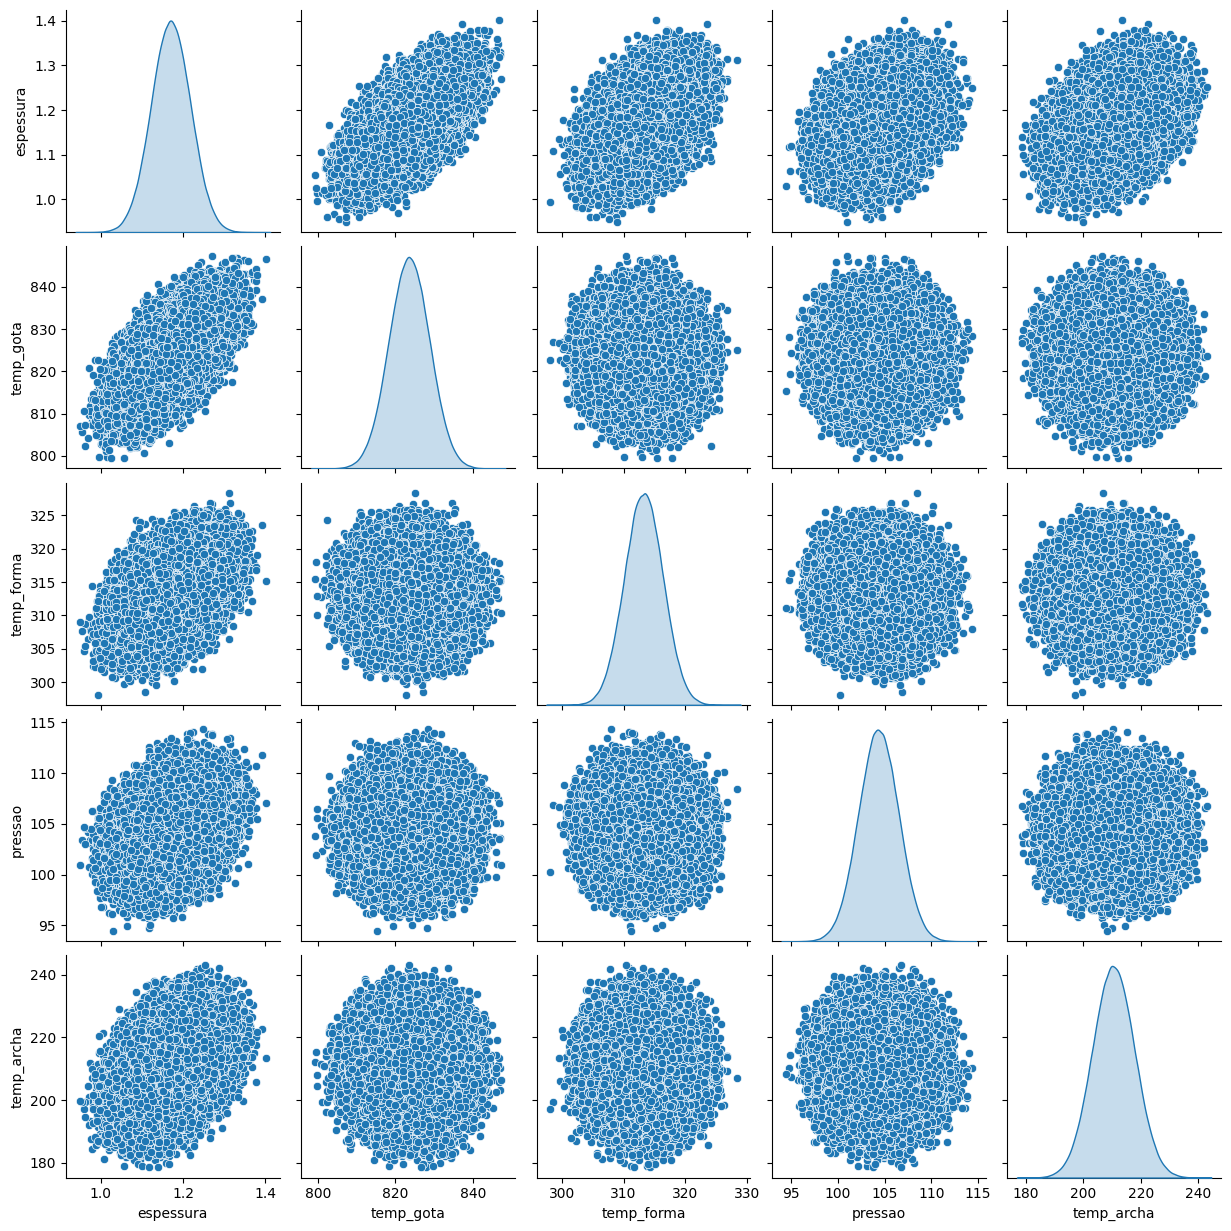

In [14]:
# Heatmap Correlação variáveis numéricas
plt.figure(figsize = (15, 15))
sns.pairplot(df[df_num], diag_kind = 'kde');

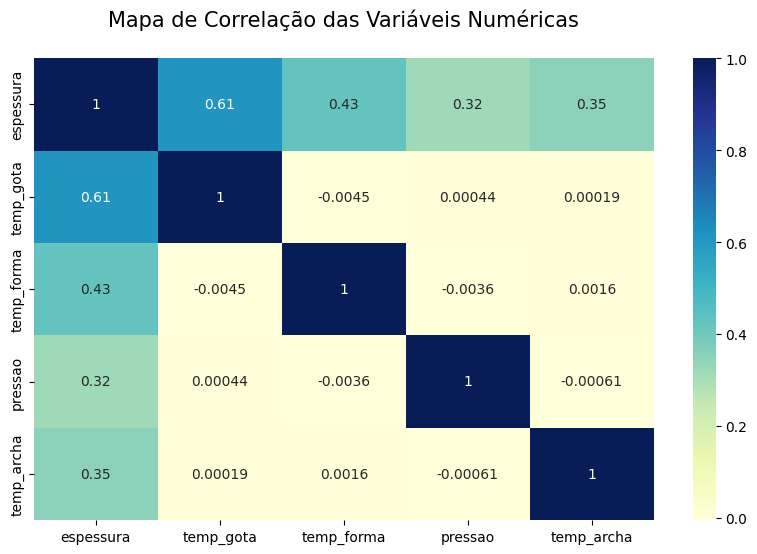

In [15]:
# Mapa Correlação variáveis numéricas
plt.figure(figsize = (10,6))
sns.heatmap(df[df_num].corr(), annot = True, cmap = 'YlGnBu')
plt.title('Mapa de Correlação das Variáveis Numéricas\n', fontsize = 15)
plt.show()

In [16]:
# IV - Information Value das variáveis categóticas
# Loop
for i in df_cat:
    
    df_ln_odds_iv = (pd.crosstab(df[i], df['aprovado'], normalize = 'columns')
                 .assign(ln_odds = lambda dfx: np.log(dfx[1] / dfx[0]))
                 .assign(iv = lambda dfx: np.sum(dfx['ln_odds'] * (dfx[1]-dfx[0]))))
    
    print('Information Value (IV):')
    print(f'{df_ln_odds_iv}\n{"-"*65}\n')

Information Value (IV):
aprovado    0    1  ln_odds   iv
aprovado                        
0         1.0  0.0     -inf  inf
1         0.0  1.0      inf  inf
-----------------------------------------------------------------

Information Value (IV):
aprovado         0         1   ln_odds        iv
molde                                           
1         0.063672  0.062422 -0.019828  0.000426
2         0.062693  0.062494 -0.003180  0.000426
3         0.061713  0.062565  0.013711  0.000426
4         0.061310  0.062563  0.020229  0.000426
5         0.062981  0.062469 -0.008158  0.000426
6         0.062145  0.062509  0.005838  0.000426
7         0.062232  0.062525  0.004700  0.000426
8         0.063211  0.062458 -0.011990  0.000426
9         0.059438  0.062747  0.054176  0.000426
10        0.062693  0.062489 -0.003252  0.000426
11        0.063499  0.062424 -0.017075  0.000426
12        0.060590  0.062649  0.033405  0.000426
13        0.063499  0.062413 -0.017255  0.000426
14        0.062779

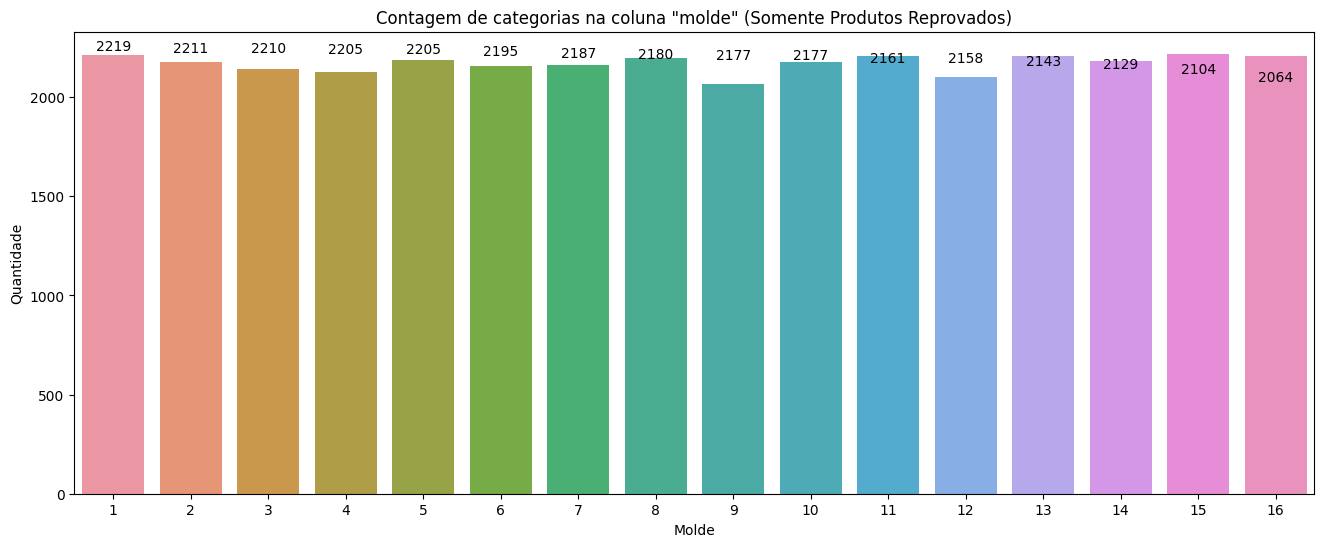

In [17]:
# Checar distribuição das reprovas entre os moldes

plt.figure(figsize=(16, 6))

# Filtrar o DataFrame pela categoria 0 da coluna 'aprovado'
filtered_df = df[df['aprovado'] == 0]

# Contar a quantidade de categorias na coluna 'molde'
counts = filtered_df['molde'].value_counts()

# Criar o gráfico de barras usando Seaborn
sns.countplot(data=filtered_df, x='molde')

# Personalizar o gráfico
plt.xlabel('Molde')
plt.ylabel('Quantidade')
plt.title('Contagem de categorias na coluna "molde" (Somente Produtos Reprovados)')

# Adicionar valores acima de cada barra
for index, value in enumerate(counts):
    plt.annotate(str(value), xy=(index, value), ha='center', va='bottom')

# Exibir o gráfico
plt.show()

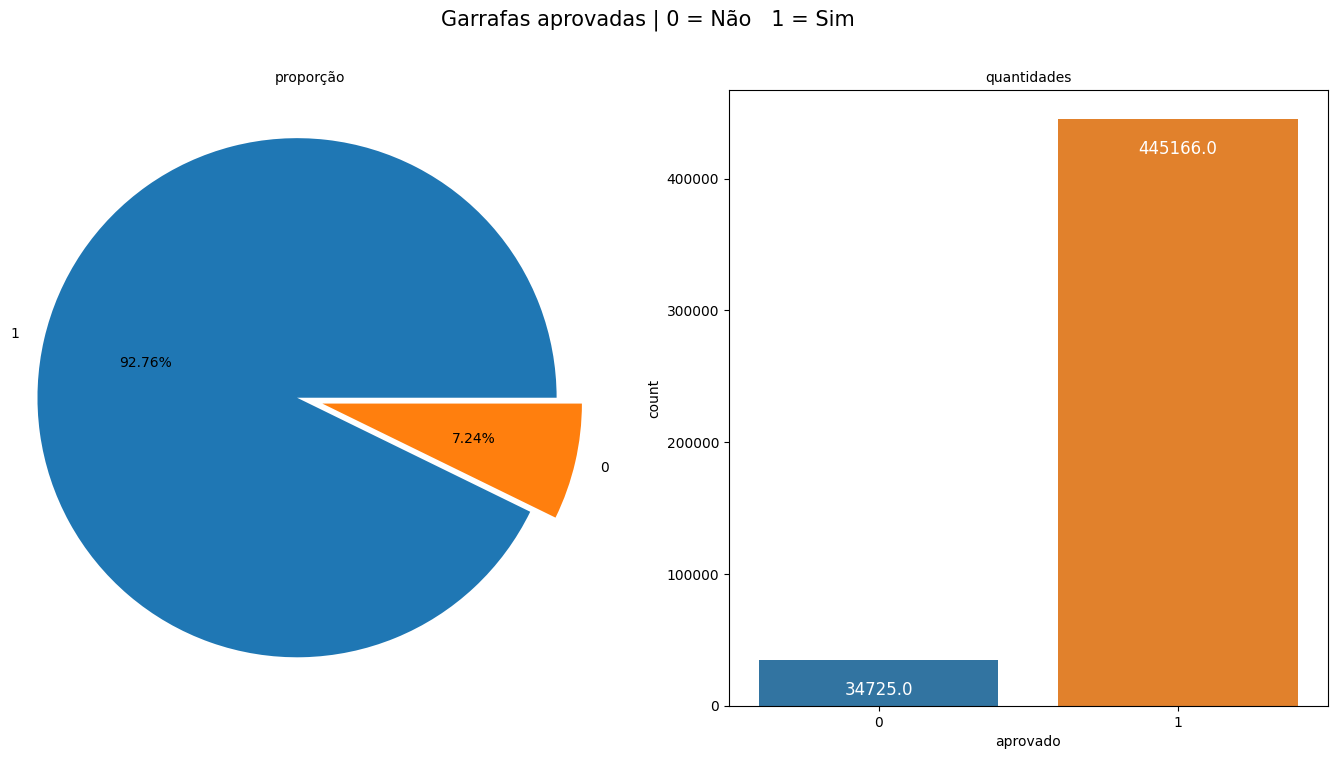

In [18]:
# Verificar o equilíbrio entre as garrafas aprovadas e reprovadas

# Figura
plt.figure(figsize = (17,8))

# Título principal
plt.suptitle('Garrafas aprovadas | 0 = Não   1 = Sim', fontsize = 15)

plt.subplot(121)

plt.pie(round(df['aprovado'].value_counts() / len(df) * 100, 2),
        labels = list(df['aprovado'].value_counts().index),
        autopct = "%.2f%%",
        explode = (0,0.1))

plt.axis("equal")
plt.title("proporção", size = 10)

plt.subplot(122)
ax = sns.countplot(data = df, x = 'aprovado')
plt.title("quantidades", fontsize = 10)
for p in ax.patches:
    ax.annotate(f'\n{p.get_height()}', 
                (p.get_x()+0.4, 
                 p.get_height()), 
                ha = 'center', 
                va = 'top', 
                color = 'white', 
                size = 12)

## Parecer preliminar
### Quanto aos dados:

- Sem valores ausentes, com boa qualidade da coleta
- Valores numéricos em forma normal, que facilita o algorítimo de ML
- Classes categóricas com baixa, ou quase nenhuma influência na variabilidade
- Desequilíbrio importante entre as categorias da variável 'aprovado'
- Correlação praticamente nula entre as variáveis numéricas, desconsiderando a variável espessura
- Variáveis com maiores correlações com a variável das espessuras:
    - temp_gota: 0.61
    - temp_forma: 0.43
### Construção do modelo de Classificação:

- Descartar variáveis 'espessura' e 'molde'
- Modelo de Classificação XGBoost
- Variável target será a variável 'aprovado'

## Desenvolvimento do Modelo com Machine Learning

### Classificação XGBoost em Python - Pré-Processamento e Balanceamento

In [19]:
## Iniciando o trabalho de Pré-Processamento
df.head()

,espessura,temp_gota,temp_forma,pressao,temp_archa,aprovado,molde
0,1.134189,824.263319,311.212995,101.065363,206.849216,1,1
1,1.106902,815.280897,310.837755,105.349291,212.221175,1,1
2,1.254478,825.975440,312.482098,108.453269,213.905909,1,1
3,1.248219,828.836946,312.256146,106.292034,214.632587,1,1
4,1.184678,824.720465,313.028271,107.403106,199.727372,1,1


In [20]:
# coletando x e y
X = df.iloc[:,1:5]
y = df['aprovado'].values

In [21]:
# variáveis explicativas
X.head()

,temp_gota,temp_forma,pressao,temp_archa
0,824.263319,311.212995,101.065363,206.849216
1,815.280897,310.837755,105.349291,212.221175
2,825.975440,312.482098,108.453269,213.905909
3,828.836946,312.256146,106.292034,214.632587
4,824.720465,313.028271,107.403106,199.727372


In [22]:
# variável target
y

array([1, 1, 1, ..., 0, 1, 1], dtype=int64)

In [23]:
# Formato de X e Y
print(X.shape, y.shape)

(479891, 4) (479891,)


In [24]:
# executa o balanceamento usando a técnica SMOTE
oversample = SMOTE()
X, y = oversample.fit_resample(X, y)

# realiza a contagem das classes
contagem = Counter(y)
print(contagem)

Counter({1: 445166, 0: 445166})


In [25]:
# Divisão em dados de treino e de teste
X_treino, X_teste, y_treino, y_teste = train_test_split(X, y, test_size = 0.30, random_state = 42)

In [26]:
# shape
X_treino.shape, X_teste.shape, y_treino.shape, y_teste.shape

((623232, 4), (267100, 4), (623232,), (267100,))

In [27]:
# objeto do modelo XGBoost
modelo = xgb.XGBClassifier(max_depth = 10, random_state=0)

In [28]:
# Treine o modelo usando os dados de treinamento
modelo.fit(X_treino, y_treino)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=10, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=0, ...)

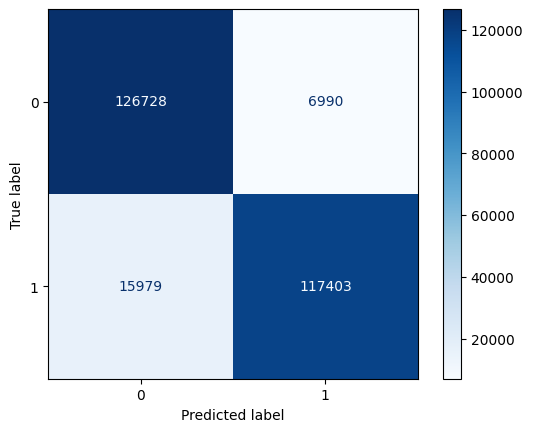

In [29]:
# Confusion Matrix do Modelo
plot_confusion_matrix(modelo, X_teste, y_teste, cmap='Blues');

In [30]:
# Gerar o relatório de classificação
y_pred = modelo.predict(X_teste)
report = classification_report(y_teste, y_pred)
print(report)

              precision    recall  f1-score   support

           0       0.89      0.95      0.92    133718
           1       0.94      0.88      0.91    133382

    accuracy                           0.91    267100
   macro avg       0.92      0.91      0.91    267100
weighted avg       0.92      0.91      0.91    267100



## Simulação

In [31]:
# dados para simulação temp_gota, temp_forma, pressao, temp_archa
dados_simulacao = [[810, 310, 110, 230],
                   [780, 310, 105, 222],
                   [790, 320, 120, 240],
                   [780, 330, 120, 240],
                   [810, 300, 90, 210]]
colunas = ['temp_gota', 'temp_forma', 'pressao', 'temp_archa']

simulacao = pd.DataFrame(dados_simulacao, columns=colunas)

In [32]:
# Fazer a previsão com o modelo treinado
previsao = modelo.predict(simulacao)

In [33]:
# Transformar array previsao em DataFrame invertendo de linha para coluna
previsao_df = pd.DataFrame(previsao, columns=["aprovado"])

# Concatenar DataFrame simulacao com previsao_df
simulacao_com_previsao = pd.concat([simulacao, previsao_df], axis=1)

In [34]:
# 0 = reprovado e 1 = aprovado
simulacao_com_previsao

,temp_gota,temp_forma,pressao,temp_archa,aprovado
0,810,310,110,230,1
1,780,310,105,222,0
2,790,320,120,240,1
3,780,330,120,240,1
4,810,300,90,210,0


Simulação efetuada e a coluna 'aprovado' mostra a previsão de acordo as outras variáveis

# FIM